In [1]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from deep_attentive_time_warping.model import BipartiteAttention
from utils import get_clf_report_dfs, plot_confusion_matrix

In [2]:
RANDOM_SEED=42 # TODO: delete?
RESULTS_DIR="./results/DATW_smaller_tau"
MODEL_NAME="DATW"

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
# y_train = data['y_train']
# X_val = data['X_val']
# y_val = data['y_val']
# X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

In [4]:
smaller_model = BipartiteAttention(input_ch=X_train.shape[-1], small_unet=True)
print(smaller_model)

BipartiteAttention(
  (unet): SmallUNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=

In [5]:
sample = X_train[0]
sample = torch.tensor(sample, dtype=torch.float32)
sample = sample.unsqueeze(0)
summary(smaller_model, input_data=[sample, sample])

Layer (type:depth-idx)                             Output Shape              Param #
BipartiteAttention                                 [1, 150, 150]             --
├─SmallUNet: 1-1                                   [1, 1, 150, 150]          --
│    └─DoubleConv: 2-1                             [1, 64, 150, 150]         --
│    │    └─Sequential: 3-1                        [1, 64, 150, 150]         41,856
│    └─Down: 2-2                                   [1, 128, 75, 75]          --
│    │    └─Sequential: 3-2                        [1, 128, 75, 75]          221,952
│    └─Down: 2-3                                   [1, 256, 37, 37]          --
│    │    └─Sequential: 3-3                        [1, 256, 37, 37]          886,272
│    └─Down: 2-4                                   [1, 256, 18, 18]          --
│    │    └─Sequential: 3-4                        [1, 256, 18, 18]          1,181,184
│    └─Up: 2-5                                     [1, 128, 37, 37]          --
│    │    └─Up

In [6]:
model = BipartiteAttention(input_ch=X_train.shape[-1], small_unet=False)
print(model)

BipartiteAttention(
  (unet): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1

In [7]:
summary(model, input_data=[sample, sample])

Layer (type:depth-idx)                             Output Shape              Param #
BipartiteAttention                                 [1, 150, 150]             --
├─UNet: 1-1                                        [1, 1, 150, 150]          --
│    └─DoubleConv: 2-1                             [1, 64, 150, 150]         --
│    │    └─Sequential: 3-1                        [1, 64, 150, 150]         41,856
│    └─Down: 2-2                                   [1, 128, 75, 75]          --
│    │    └─Sequential: 3-2                        [1, 128, 75, 75]          221,952
│    └─Down: 2-3                                   [1, 256, 37, 37]          --
│    │    └─Sequential: 3-3                        [1, 256, 37, 37]          886,272
│    └─Down: 2-4                                   [1, 512, 18, 18]          --
│    │    └─Sequential: 3-4                        [1, 512, 18, 18]          3,542,016
│    └─Down: 2-5                                   [1, 512, 9, 9]            --
│    │    └─Se

In [8]:
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_pretraining_history.pkl"), 'rb') as f:
    pretraining_history = pickle.load(f)
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_contrastive_history.pkl"), 'rb') as f:
    contrastive_history = pickle.load(f)
y_pred = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"))

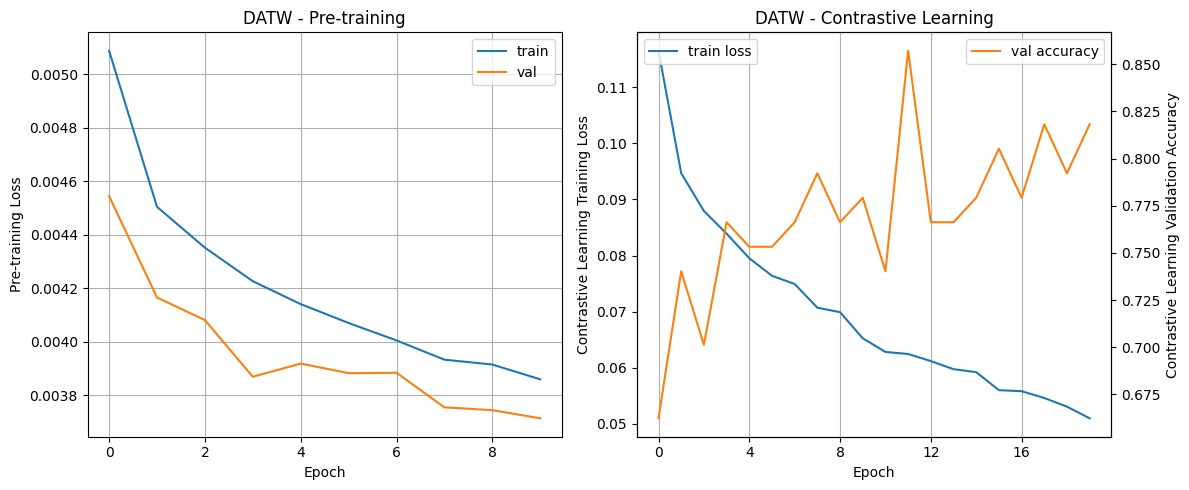

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(pretraining_history["train_loss"], label="train")
ax1.plot(pretraining_history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Pre-training")
ax1.set_ylabel("Pre-training Loss")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(contrastive_history["train_loss"], label="train loss")
ax2.set_title(f"{MODEL_NAME} - Contrastive Learning")
ax2.set_ylabel("Contrastive Learning Training Loss")
ax2.set_xlabel("Epoch")
ax2.legend(loc="upper left")
ax2.set_xticks(range(0, 21, 4))
ax2.grid(True, axis='x')

ax2_twin = ax2.twinx()
ax2_twin.plot(contrastive_history["val_acc"], label="val accuracy", color='tab:orange')
ax2_twin.set_ylabel("Contrastive Learning Validation Accuracy")
ax2_twin.legend(loc="upper right")

fig.tight_layout()

In [10]:
y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.794872,0.789637,0.785506,0.801339,0.800672,0.803125,0.794872


In [11]:
# TODO: solo del migliore
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,1.000000,1.000000,1.000000,4.000000
bigball,1.000000,0.600000,0.750000,5.000000
box,1.000000,1.000000,1.000000,5.000000
button,1.000000,0.833333,0.909091,6.000000
case,0.800000,0.800000,0.800000,5.000000
cube,0.666667,0.800000,0.727273,5.000000
cylinder,0.800000,0.800000,0.800000,5.000000
jenga,0.800000,0.800000,0.800000,5.000000
labello,0.833333,1.000000,0.909091,5.000000
lemon,0.600000,0.600000,0.600000,5.000000


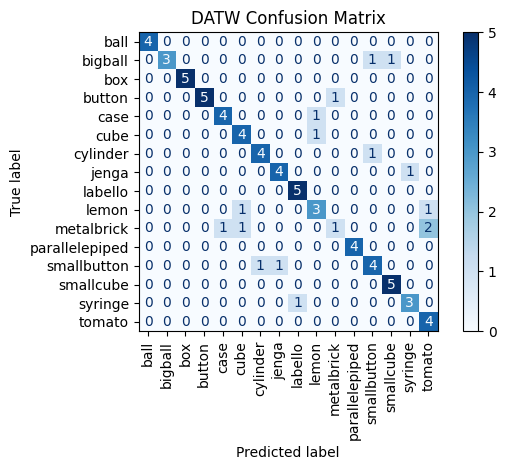

In [12]:
# TODO: solo del migliore
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)

In [ ]:
# TODO:
# contrastive learning: 
# pre-training: 64 * 100 = 6400 sample pairs
# training: 64 * 500 = 32000 sample pairs
# total number of sample pairs: (tr_size)^2=
# 32000/(tr_size**)*100 = 
# KNN, 3 (uniform)
# tau is hinge loss margin
# incrementa il numero di epoche?


# rapporto
# tau che cambia?
# modello più piccolo?

In [3]:
RESULTS_DIR = "./results/DATW_5shot_easy"
y_pred_query_full = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions_few_shot_full_ref.npy"))
y_pred_query_sub = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions_few_shot_sub_ref.npy"))
y_pred_test = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions_sub_ref.npy"))

In [4]:
base_data = np.load('./dataset/base_dataset_easy.npz')
X_train = base_data['X_train']
y_train = base_data['y_train']
X_val = base_data['X_val']
y_val = base_data['y_val']
X_test = base_data['X_test']
y_test = base_data['y_test']
y_mapping = base_data['y_mapping']

few_show_data = np.load('./dataset/5shot_dataset_easy.npz')
X_support = few_show_data['X_support']
y_support = few_show_data['y_support']
X_query = few_show_data['X_query']
y_query = few_show_data['y_query']

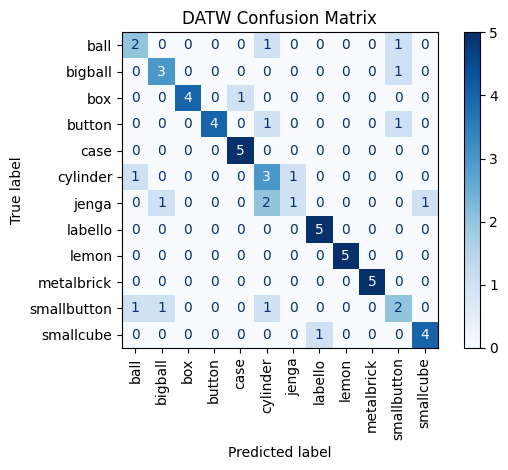

In [5]:
y_test_str = [y_mapping[label] for label in y_test]
y_pred_test_str = [y_mapping[label] for label in y_pred_test]

plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_test_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=None
)

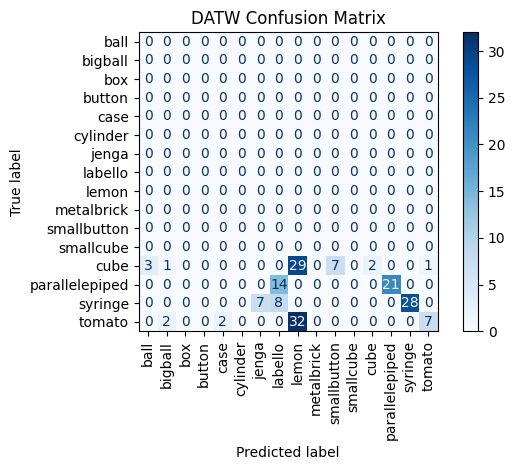

In [9]:
y_query_str = [y_mapping[label] for label in y_query]
y_pred_query_full_str = [y_mapping[label] for label in y_pred_query_full]
y_pred_query_sub_str = [y_mapping[label] for label in y_pred_query_sub]

y_support_str = [y_mapping[label] for label in y_support]
test_labels = np.unique(y_test_str)
support_labels = np.unique(y_support_str)
labels = np.concatenate((test_labels, support_labels))

plot_confusion_matrix(
    y_true=y_query_str,
    y_pred=y_pred_query_full_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=None,
    labels=labels,
)

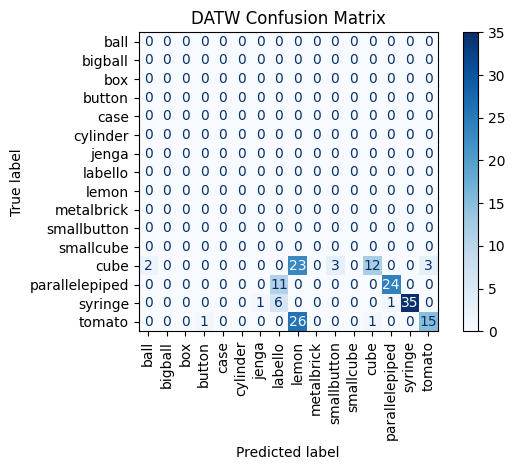

In [10]:
plot_confusion_matrix(
    y_true=y_query_str,
    y_pred=y_pred_query_sub_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=None,
    labels=labels,
)